## Imports

In [1]:
from scipy.io import arff
import time
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn import metrics as mt
import getpass
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import data and models
%run CapsoneData.ipynb
%run PhishingModels.ipynb


In [ ]:
#Get Data
email_df = get_capstonedata_as_df()

In [ ]:
email_df

In [ ]:
rf_model = run_randomforestclassifier(email_df)

## URL

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [11]:
# read URL csv files
url_df = pd.read_csv('/Users/apurv/Library/CloudStorage/OneDrive-SouthernMethodistUniversity/CapstoneA/Data/URLs.csv')
url_df.shape

(11430, 89)

In [12]:
url_df

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,phishing
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,legitimate
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,legitimate


In [13]:
# no missing data
url_df.isna().sum().sum()

0

In [14]:
url_df.status

0        legitimate
1          phishing
2          phishing
3        legitimate
4        legitimate
            ...    
11425    legitimate
11426      phishing
11427    legitimate
11428    legitimate
11429      phishing
Name: status, Length: 11430, dtype: object

In [15]:
# set status legitimate = 0 and phishing =1

url_df["status"] = [1 if x=="phishing" else 0 for x in url_df["status"]]

In [16]:
url_df['status'].value_counts()

0    5715
1    5715
Name: status, dtype: int64

In [17]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [18]:
X = url_df.drop(["url","status"],axis=1)

In [19]:
X

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,0,...,0,0,1,0,45,-1,0,1,1,4
1,77,23,1,1,0,0,0,0,0,0,...,0,1,0,0,77,5767,0,0,1,2
2,126,50,1,4,1,0,1,2,0,3,...,0,1,0,0,14,4004,5828815,0,1,0
3,18,11,0,2,0,0,0,0,0,0,...,0,1,0,0,62,-1,107721,0,0,3
4,55,15,0,2,2,0,0,0,0,0,...,0,0,1,0,224,8175,8725,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,45,17,0,2,0,0,0,0,0,0,...,0,0,0,0,448,5396,3980,0,0,6
11426,84,18,0,5,0,1,1,0,0,1,...,0,1,0,0,211,6728,0,0,1,0
11427,105,16,1,2,6,0,1,0,0,1,...,0,0,0,0,2809,8515,8,0,1,10
11428,38,30,0,2,0,0,0,0,0,0,...,0,1,0,0,85,2836,2455493,0,0,4


In [20]:
y=url_df.status

In [21]:
y

0        0
1        1
2        1
3        0
4        0
        ..
11425    0
11426    1
11427    0
11428    0
11429    1
Name: status, Length: 11430, dtype: int64

In [22]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Model 1: Logistic regression

In [23]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

In [24]:
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt

def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

# define parameters
#penalty_LR = ['l1', 'l2', 'elasticnet', 'none'] 
penalty_LR = [ 'l1', 'l2'] 
#C_LR = [0.001, 0.01, 0.1, 1, 10, 100]  
C_LR = [0.001,10, 100]  
max_iter_LR = [500]
#max_iter_LR = [500]
class_weight_LR = ['balanced']
#solver_LR = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
solver_LR = ['lbfgs', 'liblinear']
cv=5

# define grid search
param_grid_LR = dict(penalty=penalty_LR, C=C_LR, max_iter=max_iter_LR, class_weight=class_weight_LR, solver=solver_LR)

grid_search_LR = GridSearchCV(estimator=LR, param_grid=param_grid_LR, n_jobs=7, cv=cv, 
                              scoring='accuracy',error_score=0)

In [26]:
%%time
grid_result_LR = grid_search_LR.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (grid_result_LR.best_score_, grid_result_LR.best_params_))
means = grid_result_LR.cv_results_['mean_test_score']
stds = grid_result_LR.cv_results_['std_test_score']
params = grid_result_LR.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.944707 using {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'lbfgs'}
0.864742 (0.006503) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.933333 (0.003026) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.933946 (0.002364) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'lbfgs'}
0.944707 (0.004137) with: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.944619 (0.004291) with: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.944619 (0.004291) with: {'C': 10, 'clas

In [27]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_LR =grid_result_LR.best_estimator_
best_Estimator_LR

LogisticRegression(C=10, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')

In [28]:
# Display model metrics
displayModel_metrics(best_Estimator_LR, grid_result_LR, X_scaled, y, cv)


Best Accuracy with Grid Search            : 0.945

Training data Metrics

     The average accuraccy : 0.949
     The average precision : 0.953
     The average recall    : 0.946

Test data Metrics

     The average accuracy  : 0.945
     The average precision : 0.947
     The average  recall   : 0.942

Classification report

              precision    recall  f1-score   support

           1       0.95      0.94      0.94      5715
           0       0.94      0.95      0.94      5715

    accuracy                           0.94     11430
   macro avg       0.94      0.94      0.94     11430
weighted avg       0.94      0.94      0.94     11430



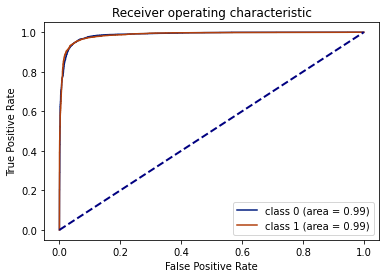

In [29]:
# Plot ROC curve
roc_curve_plot(grid_result_LR, X_scaled, y)

In [30]:
# recursive Feature elimination to identify important features
from sklearn.feature_selection import RFECV

# Instance of Recursive Feature Elimination
rfecv = RFECV(estimator=best_Estimator_LR, step=1, cv=cv, n_jobs=-1, scoring='accuracy')

# Fit RFE
rfecv.fit(X_scaled, y)

RFECV(cv=5,
      estimator=LogisticRegression(C=10, class_weight='balanced', max_iter=500,
                                   penalty='l1', solver='liblinear'),
      n_jobs=-1, scoring='accuracy')

In [31]:
# get column names
columns = pd.DataFrame(list(X))

# Get the ranking of features
ranking = pd.DataFrame(rfecv.ranking_)

# ranking and their importance
rfe_selected = pd.DataFrame()
rfe_selected  = pd.concat([columns, ranking], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking']
rfe_selected_sorted = rfe_selected.sort_values(by=['Ranking'], ascending=True)
print(rfe_selected_sorted)

                  Feature Name  Ranking
0                   length_url        1
32               nb_subdomains        1
35          shortening_service        1
40                 char_repeat        1
41          shortest_words_raw        1
42          shortest_word_host        1
85                google_index        1
44           longest_words_raw        1
46           longest_word_path        1
47               avg_words_raw        1
48               avg_word_host        1
50                 phish_hints        1
52          brand_in_subdomain        1
53               brand_in_path        1
56               nb_hyperlinks        1
57         ratio_intHyperlinks        1
58         ratio_extHyperlinks        1
62        ratio_extRedirection        1
70              ratio_extMedia        1
74                 safe_anchor        1
78             domain_in_title        1
79       domain_with_copyright        1
80     whois_registered_domain        1
82                  domain_age        1


## SVM

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [31]:
svc_model = SVC(C=1, kernel = 'linear')

In [ ]:
svc_model.fit(X,y)

In [ ]:
svc_model.predict(X)

In [ ]:
accuracy_score(svc_model.predict(X),y)

In [ ]:
cross_val_score(svc_model,X,y,cv=5, scoring="accuracy")

## Heatmap

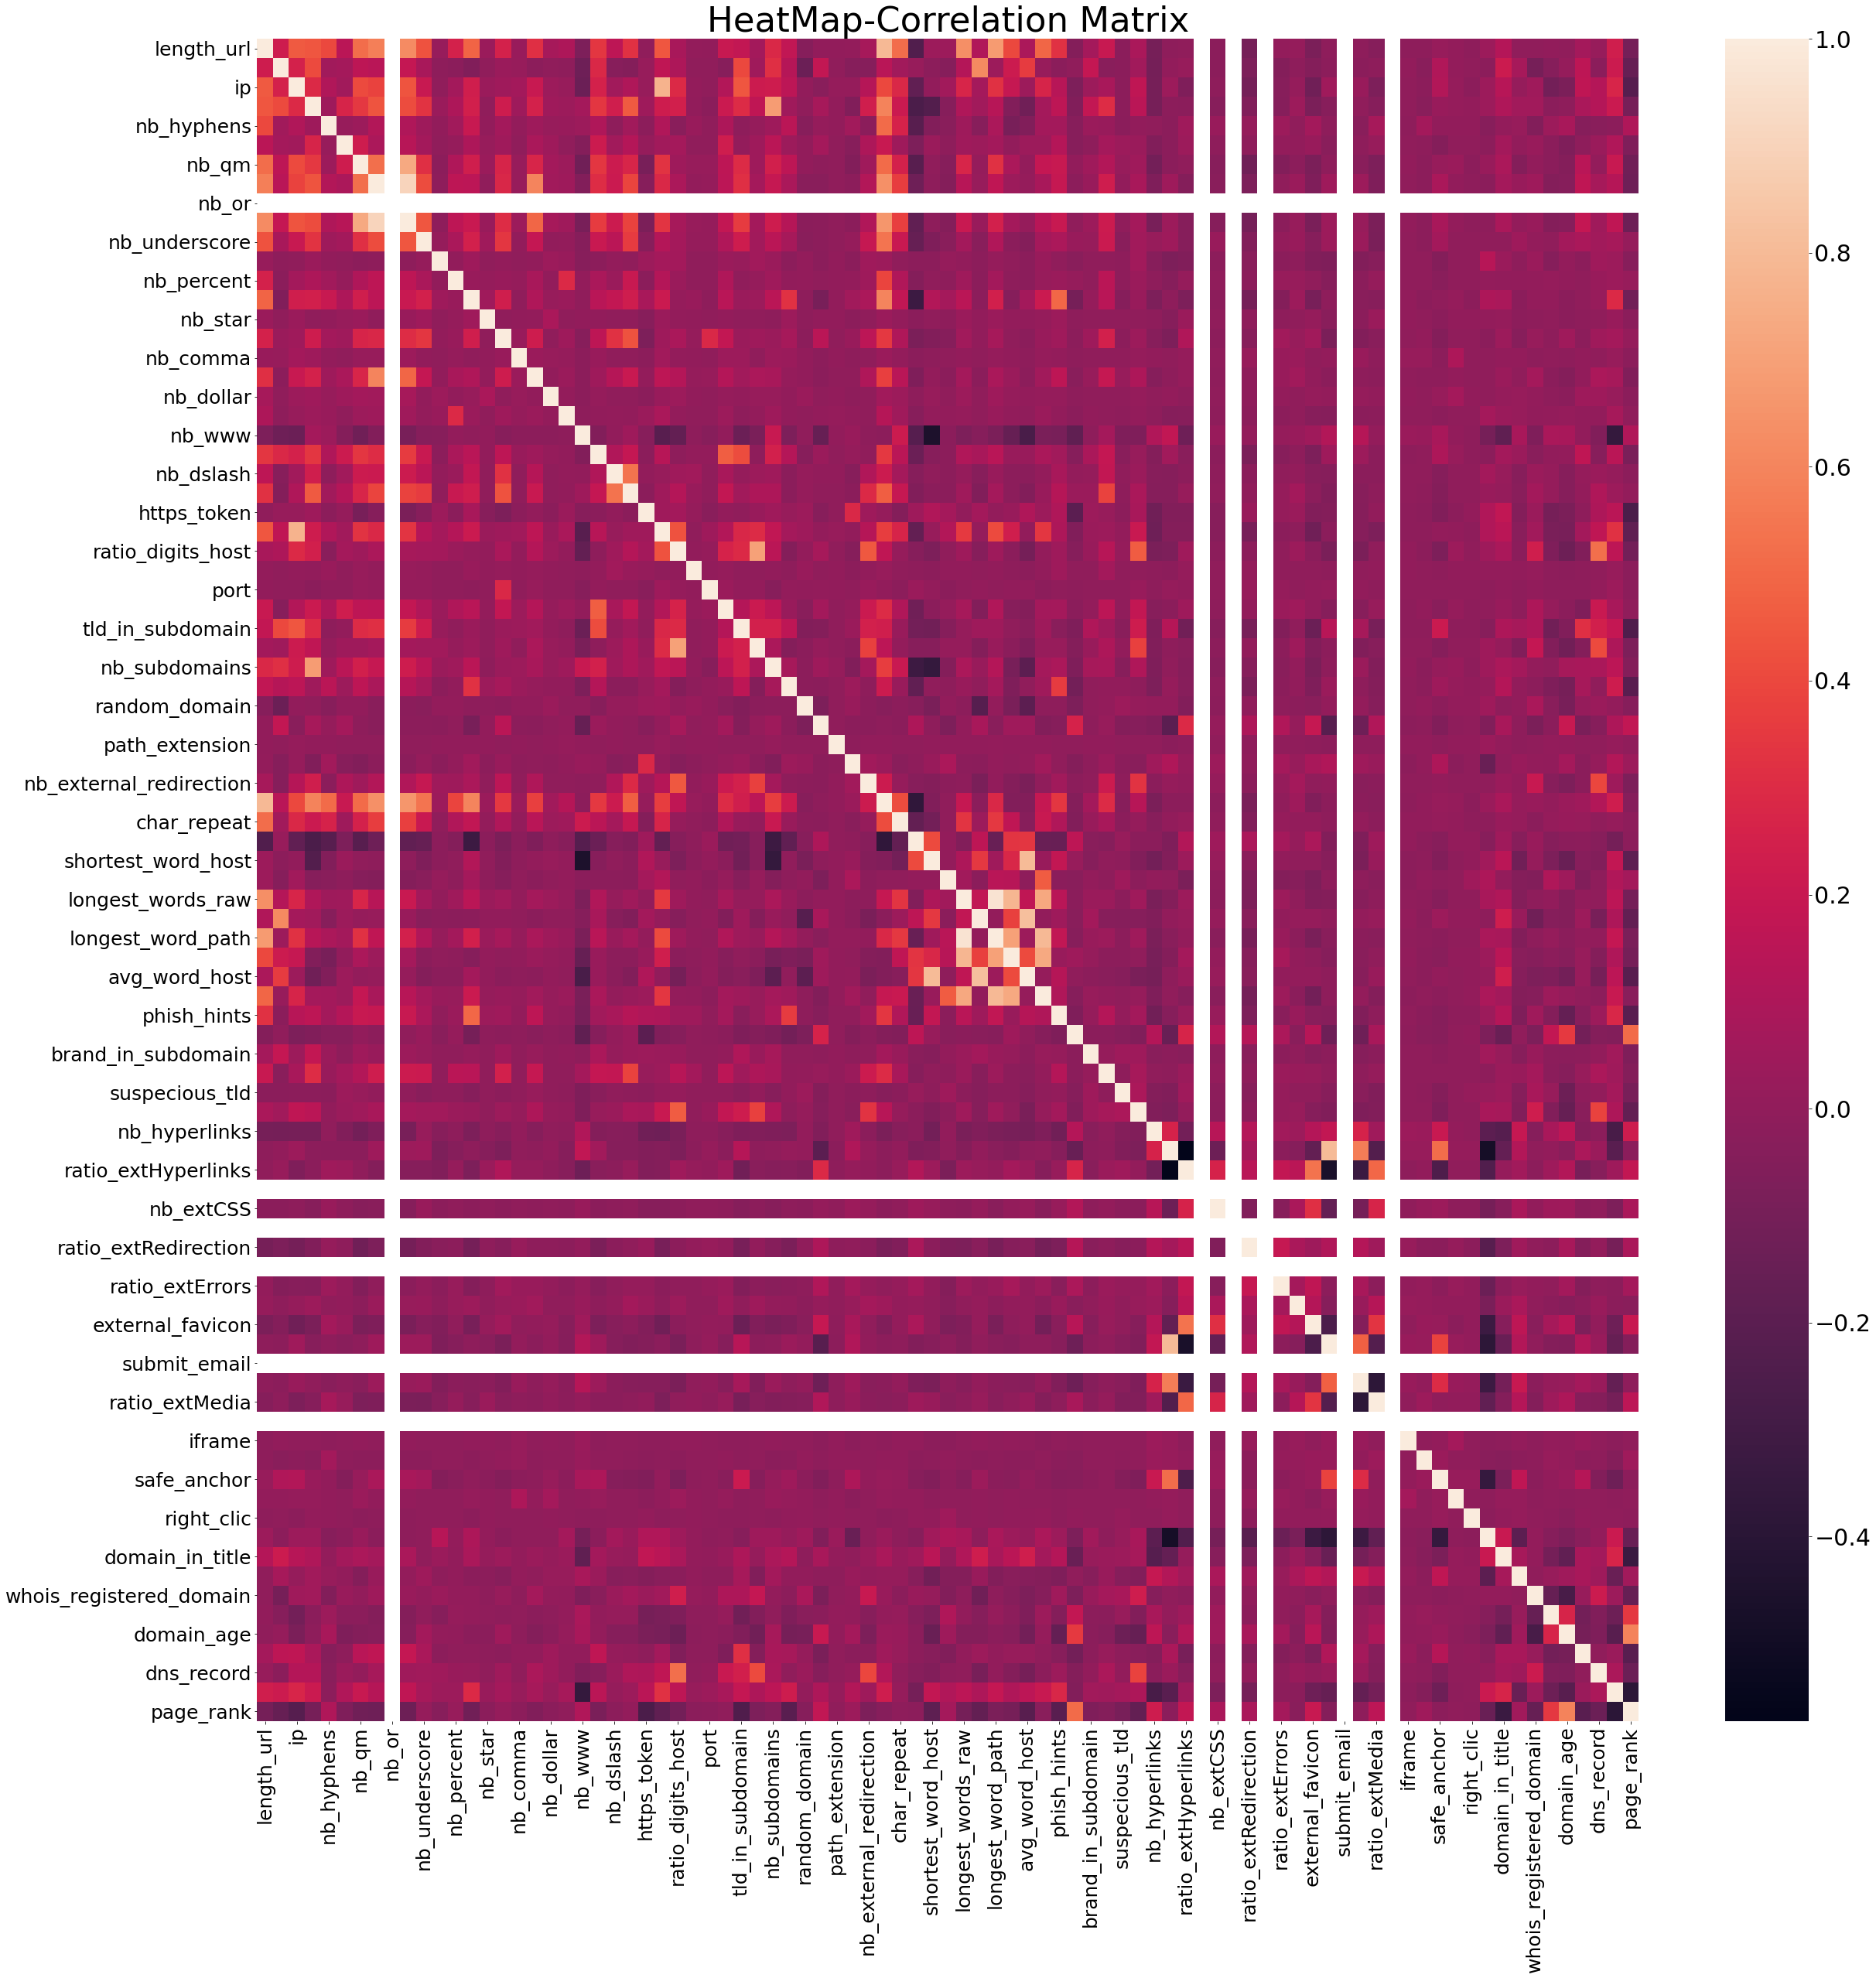

In [4]:
#heatmap - correlation matrix
plt.figure(figsize=(40, 40)) #code reference (5-1)
plt.xticks(rotation=90,fontsize = 25)
plt.yticks(rotation=180, fontsize = 25)
ax=sns.heatmap(url_df.corr(), annot=False, cbar=True)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.title('HeatMap-Correlation Matrix',fontsize = 45)
plt.show()


In [5]:
#https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
# to drop features with colliniarity more than 95%
pd.set_option('display.max_rows', 100)

corr_df = pd.DataFrame(url_df.corr().abs())
corr_df.head(100)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
length_url,1.000000,0.223025,0.453961,0.443589,0.399564,0.150739,0.520930,0.576268,NaN,0.621745,...,0.041879,0.125159,0.006476,0.007082,0.002799,0.006798,0.072205,0.023357,0.236395,0.102582
length_hostname,0.223025,1.000000,0.252013,0.408956,0.057702,0.071793,0.162400,0.145617,NaN,0.183405,...,0.015054,0.217284,0.074707,0.097794,0.041081,0.013854,0.163238,0.023344,0.213990,0.159342
ip,0.453961,0.252013,1.000000,0.288398,0.109860,0.059401,0.405434,0.383262,NaN,0.440972,...,0.037971,0.137716,0.014561,0.053246,0.108869,0.077020,0.167930,0.127823,0.270743,0.218968
nb_dots,0.443589,0.408956,0.288398,1.000000,0.045099,0.263283,0.347411,0.435798,NaN,0.414902,...,0.040875,0.107789,0.055560,0.056407,0.024117,0.007818,0.087969,0.126659,0.209616,0.097312
nb_hyphens,0.399564,0.057702,0.109860,0.045099,1.000000,0.018770,0.036804,0.120487,NaN,0.107050,...,0.033302,0.006909,0.020297,0.055794,0.038163,0.080104,0.041464,0.031477,0.018828,0.104341
nb_at,0.150739,0.071793,0.059401,0.263283,0.018770,1.000000,0.224070,0.096444,NaN,0.138390,...,0.018200,0.063324,0.000731,0.024869,0.023614,0.067334,0.009459,0.031611,0.113217,0.066356
nb_qm,0.520930,0.162400,0.405434,0.347411,0.036804,0.224070,1.000000,0.525861,NaN,0.731735,...,0.027344,0.091976,0.045188,0.001269,0.023928,0.045623,0.143777,0.009441,0.201260,0.123852
nb_and,0.576268,0.145617,0.383262,0.435798,0.120487,0.096444,0.525861,1.000000,NaN,0.906404,...,0.022704,0.071216,0.026322,0.046641,0.046672,0.043933,0.164797,0.076372,0.129093,0.126164
nb_or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nb_eq,0.621745,0.183405,0.440972,0.414902,0.107050,0.138390,0.731735,0.906404,NaN,1.000000,...,0.010362,0.088081,0.006372,0.024540,0.044946,0.039726,0.187809,0.052159,0.167385,0.133089


In [6]:
# Multi Colliniarity analysis on Independent variables 
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool))
print(upper_tri)

                            length_url  length_hostname        ip   nb_dots  \
length_url                         NaN         0.223025  0.453961  0.443589   
length_hostname                    NaN              NaN  0.252013  0.408956   
ip                                 NaN              NaN       NaN  0.288398   
nb_dots                            NaN              NaN       NaN       NaN   
nb_hyphens                         NaN              NaN       NaN       NaN   
nb_at                              NaN              NaN       NaN       NaN   
nb_qm                              NaN              NaN       NaN       NaN   
nb_and                             NaN              NaN       NaN       NaN   
nb_or                              NaN              NaN       NaN       NaN   
nb_eq                              NaN              NaN       NaN       NaN   
nb_underscore                      NaN              NaN       NaN       NaN   
nb_tilde                           NaN              

In [8]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print((to_drop))

['nb_eq', 'longest_word_path']


#### Helper Function

In [68]:
# Model Metrics
def displayModel_metrics(best_model, grid_model, features, target, cv):   
    start = time.time()
    cv_results = cross_validate(best_model, features, target, cv=cv, scoring=['accuracy','precision','recall','f1'], n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_accuracy'])
    print(' ')
    print('Best Accuracy   :  {:.3f}'.format(grid_model.best_score_))
    print('Mean Accuracy   : ', cv_results['test_accuracy'].mean())
    print('Mean Precision  : ', cv_results['test_precision'].mean())
    print('Mean Recall     : ', cv_results['test_recall'].mean())
    #print('Mean F-Score   : ', cv_results['fscore'].mean())
    #print('Mean Fit Time   : ', cv_results['fit_time'].mean())
    #print('Mean Score Time : ', cv_results['score_time'].mean())
    #print('CV Time         : ', elapsed_time)
    return

# ROC curve plot
def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()    

#### Model : XGBoost with default parameters  

In [33]:
xgb_clf = xgb.XGBClassifier(random_state=1234)

In [34]:
xgb_clf.fit(X_scaled, y)

xgb_clf.get_params()

[15:03:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1234,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [35]:
y_hat = xgb_clf.predict(X_scaled)
accuracy_score(y_hat, y)

1.0

In [36]:
confusion_matrix(y, y_hat)

array([[5715,    0],
       [   0, 5715]])

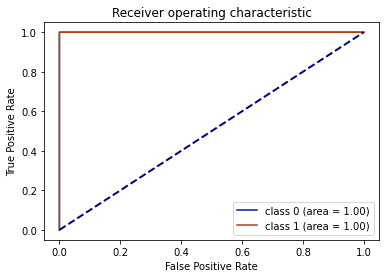

In [37]:
# ROC curve for XGB Classifier
roc_curve_plot(xgb_clf, X_scaled, y)

Text(0.5, 1.0, 'Precision-Recall Curve')

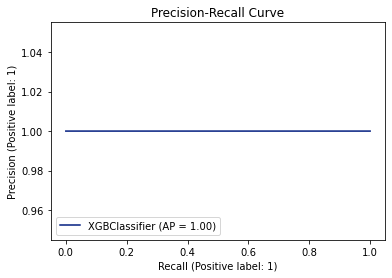

In [38]:
disp = plot_precision_recall_curve(xgb_clf, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

In [70]:
cv_df = pd.DataFrame(cross_validate(xgb_clf, X_scaled, y, cv=cv, scoring=['accuracy','precision','recall', 'f1'], n_jobs=-1))
cv_df

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,6.164209,0.008942,0.970691,0.975265,0.965879,0.970549
1,7.759363,0.013755,0.967629,0.963573,0.972003,0.967770
2,7.761071,0.013991,0.970254,0.968614,0.972003,0.970306
3,7.704401,0.013965,0.965442,0.961806,0.969379,0.965577
4,7.588790,0.023092,0.972003,0.975330,0.968504,0.971905


[15:27:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:07] WARNING: /Users/runner/miniforge3/cond

### Randomized Search

In [40]:
XGB = xgb.XGBClassifier()

# define parameters       
clf_n_estimators_XGB = [200]
clf_learning_rate_XGB =  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
clf_max_depth_XGB = range(3, 15)
clf_colsample_bytree_XFB = [i/10.0 for i in range(1, 3)]
clf_gamma_XGB = [0.01, 0.05, 0.1, 0.2, 0.3] 
lambda_XGB = [0.01, 0.05, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
min_child_weight = [0.1, 0.9, 0.95, 2, 3]
random_state_XGB = [1234]

# define random search
param_random_XGB = dict(n_estimators=clf_n_estimators_XGB, learning_rate=clf_learning_rate_XGB, 
                     max_depth=clf_max_depth_XGB, colsample_bytree = clf_colsample_bytree_XFB,
                    gamma=clf_gamma_XGB, reg_lambda=lambda_XGB, random_state=random_state_XGB)


search_XGB = RandomizedSearchCV(estimator=XGB, param_distributions=param_random_XGB, n_jobs=3, cv=cv, 
                               scoring='accuracy',n_iter=20, verbose=5)

In [41]:
%%time
result_XGB = search_XGB.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (result_XGB.best_score_, result_XGB.best_params_))
means = result_XGB.cv_results_['mean_test_score']
stds = result_XGB.cv_results_['std_test_score']
params = result_XGB.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[15:03:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:56] WARNING: /Users/runner/miniforge3/cond

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

[15:10:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.972091 using {'reg_lambda': 0.05, 'random_state': 1234, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.2}
0.972091 (0.002114) with: {'reg_lambda': 0.05, 'random_state': 1234, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.2}
0.967192 (0.001206) with: {'reg_lambda': 50.0, 'random_state': 1234, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.2}
0.916973 (0.002254) with: {'reg_lambda': 50.0, 'random_state': 1234, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 0.1}
0.926159 (0.002338

In [42]:
# # The GridSearch algorithm determined the following optimal parameters
best_Estimator_XGB =result_XGB.best_estimator_
Coef_weights_XGB = result_XGB.best_estimator_.feature_importances_
best_Estimator_XGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              enable_categorical=False, gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=1234, reg_alpha=0, reg_lambda=0.05,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [69]:
# Display model metrics
displayModel_metrics(best_Estimator_XGB, result_XGB, X_scaled, y, cv)

/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apurv/opt/anaconda3/envs/msds/lib/python3

Fold Scores:
 
[0.97244094 0.97069116 0.97506562 0.96894138 0.97331584]
 
Best Accuracy   :  0.972
Mean Accuracy   :  0.9720909886264216
Mean Precision  :  0.9728427147866728
Mean Recall     :  0.9713035870516185


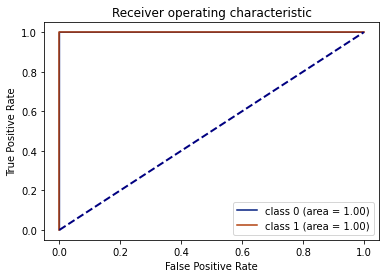

In [46]:
# ROC curve for Random Forest Classifier
roc_curve_plot(result_XGB, X_scaled, y)

Text(0.5, 1.0, 'Precision-Recall Curve')

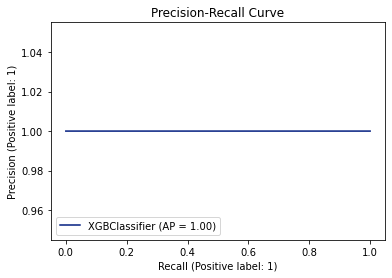

In [47]:
disp = plot_precision_recall_curve(best_Estimator_XGB, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

In [49]:
from sklearn import metrics
precision, recall, threshold = metrics.precision_recall_curve(y, best_Estimator_XGB.predict_proba(X_scaled)[:, 1])

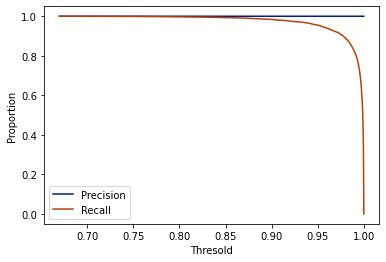

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], label='Recall')
plt.xlabel('Thresold')
plt.ylabel('Proportion')
plt.legend()

In [51]:
mal95_ind = np.argmin(recall >= 0.95)-1
mal95_thresh = threshold[mal95_ind]
mal95_precision = precision[mal95_ind]
mal95_recall = recall[mal95_ind]

print("Threshold:", mal95_thresh)
print("Precision:", mal95_precision)
print("Recall:", mal95_recall)

Threshold: 0.953662
Precision: 1.0
Recall: 0.9501312335958005


### Feature Importance with XGB

In [66]:
# Important features with their weights 

imp_feature_df = pd.DataFrame({'feature_names':X, 
                               'Coef_weights':Coef_weights_XGB})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
85,google_index,0.387692
86,page_rank,0.046365
50,phish_hints,0.037528
2,ip,0.034172
20,nb_www,0.032519
83,web_traffic,0.022987
26,ratio_digits_host,0.022968
53,brand_in_path,0.019398
84,dns_record,0.018600
17,nb_semicolumn,0.015115


Text(0, 0.5, 'Feature Names')

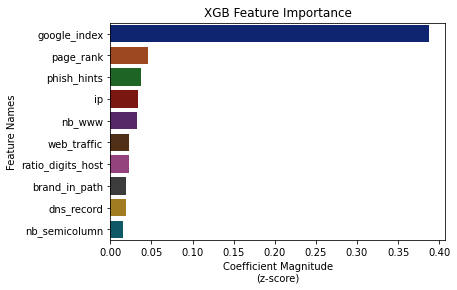

In [67]:
# Visulization of important features 
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df.head(10), orient= 'h')
ax.set_title("XGB Feature Importance")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

#### Model: Random Forest with default parameters

In [71]:
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=1234)
rf_clf.fit(X_scaled, y)

rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [72]:
y_hat = rf_clf.predict(X_scaled)
accuracy_score(y_hat, y)

1.0

In [73]:
confusion_matrix(y, y_hat)

array([[5715,    0],
       [   0, 5715]])

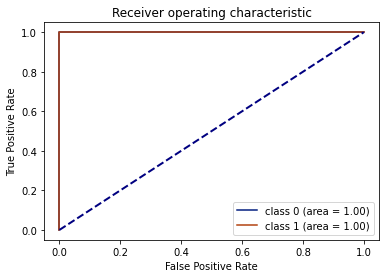

In [74]:
# ROC curve for Random Forest Classifier
roc_curve_plot(rf_clf, X_scaled, y)

Text(0.5, 1.0, 'Precision-Recall Curve')

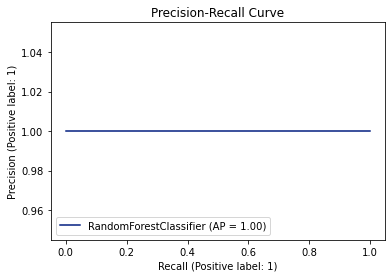

In [75]:
disp = plot_precision_recall_curve(rf_clf, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

In [76]:
# cross validation
cv_df = pd.DataFrame(cross_validate(rf_clf, X_scaled, y, cv=cv, scoring=['accuracy','precision','recall', 'f1'], n_jobs=-1))
cv_df

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,1.662517,0.059266,0.970691,0.974427,0.966754,0.970575
1,1.671000,0.059915,0.965004,0.965004,0.965004,0.965004
2,1.662482,0.058032,0.965442,0.965035,0.965879,0.965457
3,1.656911,0.058612,0.959755,0.958152,0.961505,0.959825
4,1.656748,0.060719,0.967192,0.970899,0.963255,0.967062


In [77]:
RF = RandomForestClassifier()

# define parameters       
max_depth_RF = [5, 7, 8, 10, 12]
random_state_RF = [1234]
n_estimators_RF =  [100]
criterion_RF = ['entropy']
min_samples_leaf_RF = [3, 4, 5]
min_samples_split_RF = [8, 10, 12]
class_weight_RF = ['balanced']

# define random search
param_random_RF = dict(n_estimators=n_estimators_RF, max_depth=max_depth_RF, random_state=random_state_RF,
                     criterion=criterion_RF, min_samples_leaf=min_samples_leaf_RF,
                    min_samples_split=min_samples_split_RF, class_weight=class_weight_RF)


search_RF = RandomizedSearchCV(estimator=RF, param_distributions=param_random_RF, n_jobs=3, cv=cv, 
                               scoring='accuracy',n_iter=20, verbose=5)

In [78]:
%%time
result_RF = search_RF.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (result_RF.best_score_, result_RF.best_params_))
means = result_RF.cv_results_['mean_test_score']
stds = result_RF.cv_results_['std_test_score']
params = result_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.960805 using {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_depth': 12, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.951444 (0.003489) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 7, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.954681 (0.004659) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.950831 (0.003150) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.957918 (0.004369) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.943220 (0

In [79]:
# # The GridSearch algorithm determined the following optimal parameters
best_Estimator_RF =result_RF.best_estimator_
Coef_weights_RF = result_RF.best_estimator_.feature_importances_
best_Estimator_RF

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=5, min_samples_split=12,
                       random_state=1234)

In [80]:
# Display model metrics
displayModel_metrics(best_Estimator_RF, result_RF, X_scaled, y, cv)

[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=1234;, score=0.952 total time=   1.0s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=1234;, score=0.958 total time=   1.1s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=1234;, score=0.953 total time=   1.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=1234;, score=0.960 total time=   1.0s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=1234;, score=0.946 total time=   1.1s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_spli

Fold Scores:
 
[0.96456693 0.96325459 0.96106737 0.95100612 0.96412948]
 
Best Accuracy   :  0.961
Mean Accuracy   :  0.9608048993875766
Mean Precision  :  0.9611365224908498
Mean Recall     :  0.9604549431321084


In [81]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(best_Estimator_RF, X_scaled, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)

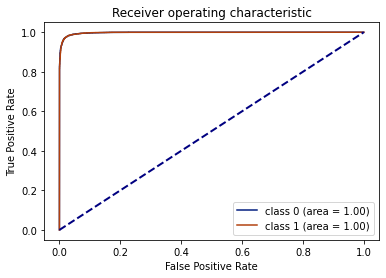

In [82]:
# ROC curve for Random Forest Classifier
roc_curve_plot(result_RF, X_scaled, y)

Text(0.5, 1.0, 'Precision-Recall Curve')

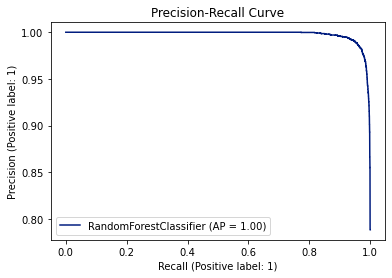

In [83]:
disp = plot_precision_recall_curve(best_Estimator_RF, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

In [84]:
precision, recall, threshold = metrics.precision_recall_curve(y, best_Estimator_RF.predict_proba(X_scaled)[:, 1])

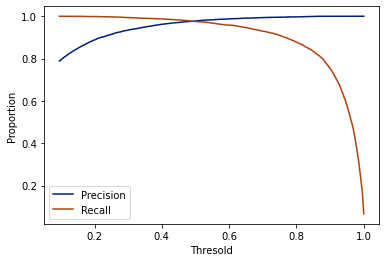

In [85]:
%matplotlib inline
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], label='Recall')
plt.xlabel('Thresold')
plt.ylabel('Proportion')
plt.legend()

In [86]:
mal95_ind = np.argmin(recall >= 0.95)-1
mal95_thresh = threshold[mal95_ind]
mal95_precision = precision[mal95_ind]
mal95_recall = recall[mal95_ind]

print("Threshold:", mal95_thresh)
print("Precision:", mal95_precision)
print("Recall:", mal95_recall)

Threshold: 0.6370283867755814
Precision: 0.9901531728665208
Recall: 0.9501312335958005


In [87]:
# Important features with their weights 
imp_feature_df = pd.DataFrame({'feature_names':X, 
                               'Coef_weights':Coef_weights_RF})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
85,google_index,0.206762
86,page_rank,0.130008
56,nb_hyperlinks,0.078896
83,web_traffic,0.057453
20,nb_www,0.053496
46,longest_word_path,0.036254
82,domain_age,0.032414
58,ratio_extHyperlinks,0.030032
50,phish_hints,0.025939
57,ratio_intHyperlinks,0.021734


Text(0, 0.5, 'Feature Names')

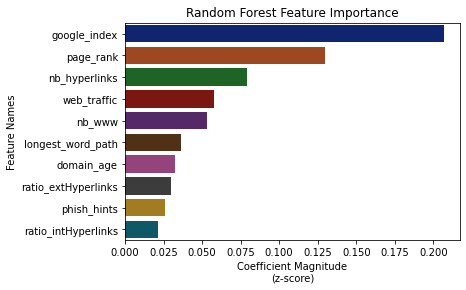

In [88]:
# Visulization of important features 
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df.head(10), orient= 'h')
ax.set_title("Random Forest Feature Importance")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")